## 1. Loading packages

In [1]:
#Packages 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 2. Fixed input values of the model

In [17]:
#Fixed input values

viscosity = 1*10**(-6) #kinematic viscosity
rho = 1000
g = 9.81
x = 2 #number of screws
eta_0 = 0.6     #open water eff
eta_r = 0.98     #relative rotative eff
eta_t = 0.98     #transmission eff
eta_g = 0.96     #gearing eff

#Fixed input values, ship related (values of M9)

L = 110
B = 11.4
T = 2.2

C_B = 0.85      #block coefficient 

P_installed = 1750 #kW  

c_stern = 0

one_k2 = 2.5 #appendage resistance factor


In [18]:
#Ship related values, calculated from fixed input values

C_M = 1.006 - 0.0056 * C_B **(-3.56)       #midshipcoefficient
C_wp = (1+2 * C_B)/3                       #waterplane coefficient
C_p = C_B / C_M                            #prismatic coefficient

delta = C_B * L * B * T                    #water displacement

lcb = -13.5 + 19.4 * C_p                   #longitudinal position of the centre of buoyancy as % of L
L_R = L * (1 - C_p + (0.06 * C_p * lcb)/(4 * C_p -1))   #Length of the run

A_T = 0.2 * B * T     #area immersed transom

#Total wet surface area (S_T), wet area of appendages (S_APP) and wet area of flat bottom (S_B)
S_T = L*(2*T + B) * np.sqrt(C_M) * (0.453 + 0.4425 * C_B - 0.2862* C_M - 0.003467 * (B/T) + 0.3696 * C_wp) #+ 2.38 * (A_BT / C_B)
S_APP = 0.05 * S_T
S_B = L * B

#Screw diameter
D_s = 0.7 * T

In [19]:
print(C_p)

0.8534029414646301


## 3. Variable velocity 

In [20]:
V_0 = np.linspace(0.1, 8, 200)

V_gem = 3.7 #m/s #hardcoded, later on this is determined from AIS data

## 4. Method to calculate different resistance components a ship experiences

Method based on the division of Holtrop & Mennen, with some adjustments made in order to incorporate the shallow water effects

### A) Karpov velocity correction for limited water depths

In [21]:
############ Additional wave making resistance - Karpov #############
R_e = V_0 * L / viscosity

def karpov(h, F_n):
    
    #The Froude number used in the Karpov method is the depth related froude number F_nh
    
    #The different alpha** curves are determined with a sixth power polynomial approximation in Excel
    #A distinction is made between different ranges of Froude numbers, because this resulted in a better approximation of the curve
    
    if F_n <= 0.4:
        
        if 0 <= h/T < 1.75:
            alpha_xx = (-4*10**(-12)) * F_n**3 - 0.2143 * F_n**2 -0.0643 * F_n + 0.9997
        elif 1.75 <= h/T < 2.25:
            alpha_xx = -0.8333 * F_n**3 + 0.25 * F_n**2 - 0.0167 * F_n + 1
        elif 2.25 <= h/T < 2.75:
            alpha_xx = -1.25 * F_n**4 + 0.5833 * F_n**3 - 0.0375 * F_n**2 - 0.0108 * F_n + 1
        elif h/T >= 2.75:
            alpha_xx = 1
    
    elif F_n > 0.4:
        if 0 <= h/T < 1.75:
            alpha_xx = -0.9274 * F_n**6 + 9.5953 * F_n**5 - 37.197 * F_n**4 + 69.666 * F_n**3 - 65.391 * F_n**2 + 28.025 * F_n - 3.4143
        elif 1.75 <= h/T < 2.25:
            alpha_xx = 2.2152 * F_n**6 - 11.852 * F_n**5 + 21.499 * F_n**4 - 12.174 * F_n**3 - 4.7873 * F_n**2 + 5.8662 * F_n - 0.2652
        elif 2.25 <= h/T < 2.75:
            alpha_xx = 1.2205 * F_n**6 - 5.4999 * F_n**5 + 5.7966 * F_n**4 + 6.6491 * F_n**3 - 16.123 * F_n**2 + 9.2016 * F_n - 0.6342
        elif 2.75 <= h/T < 3.25:
            alpha_xx = -0.4085 * F_n**6 + 4.534 * F_n**5 - 18.443 * F_n**4 + 35.744 * F_n**3 - 34.381 * F_n**2 + 15.042 * F_n - 1.3807
        elif 3.25 <= h/T < 3.75:
            alpha_xx = 0.4078 * F_n **6 - 0.919 * F_n**5 - 3.8292 * F_n**4 + 15.738 * F_n**3 - 19.766 * F_n**2 + 9.7466 * F_n - 0.6409
        elif 3.75 <= h/T < 4.5:
            alpha_xx = 0.3067 * F_n**6 - 0.3404 * F_n**5 - 5.0511 * F_n**4 + 16.892 * F_n**3 - 20.265 * F_n**2 + 9.9002 * F_n - 0.6712
        elif 4.5 <= h/T < 5.5:
            alpha_xx = 0.3212 * F_n**6 - 0.3559 * F_n**5 - 5.1056 * F_n**4 + 16.926 * F_n**3 - 20.253 * F_n**2 + 10.013 * F_n - 0.7196
        elif 5.5 <= h/T < 6.5:
            alpha_xx = 0.9252 * F_n**6 - 4.2574 * F_n**5 + 5.0363 * F_n **4 + 3.3282 * F_n**3 - 10.367 * F_n**2 + 6.3993 * F_n - 0.2074
        elif 6.5 <= h/T < 7.5:
            alpha_xx = 0.8442 * F_n**6 - 4.0261 * F_n**5 + 5.313 * F_n **4 + 1.6442 * F_n**3 - 8.1848 * F_n**2 + 5.3209 * F_n - 0.0267
        elif 7.5 <= h/T < 8.5:
            alpha_xx = 0.1211 * F_n**6 + 0.628 * F_n**5 - 6.5106 * F_n**4 + 16.7 * F_n**3 - 18.267 * F_n**2 + 8.7077 * F_n - 0.4745
        
                
        elif 8.5 <= h/T < 9.5:
            if F_n < 0.6:
                alpha_xx = 1
            elif F_n >= 0.6:
                alpha_xx = -6.4069 * F_n**6 + 47.308 * F_n**5 - 141.93 * F_n**4 + 220.23 * F_n**3 - 185.05 * F_n**2 + 79.25 * F_n - 12.484
        elif h/T >= 9.5: 
            if F_n < 0.6:
                alpha_xx = 1
            elif F_n >= 0.6:
                alpha_xx = -6.0727 * F_n**6 + 44.97 * F_n**5 - 135.21 * F_n**4 + 210.13 * F_n**3 - 176.72 * F_n**2 + 75.728 * F_n - 11.893
    
    return alpha_xx


In [22]:
h1 = 6
h2 = 4
h3 = 2.5
h4 = 4
h5 = 4

F_nh1 = V_0 / np.sqrt(g * h1)
F_nh2 = V_0 / np.sqrt(g * h2)
F_nh3 = V_0 / np.sqrt(g * h3)
F_nh4 = V_0 / np.sqrt(g * h4)
F_nh5 = V_0 / np.sqrt(g * h4)

#The corrected velocity V2 (Karpov) is going to be applied in all resistance components of the Holtrop and Mennen method
#Except for frictional resistance

V2_1 = np.zeros(len(F_nh1))
V2_2 = np.zeros(len(F_nh1))
V2_3 = np.zeros(len(F_nh1))
V2_4 = np.zeros(len(F_nh1))
V2_5 = np.zeros(len(F_nh1))

for i in range(len(F_nh1)):
    V2_1[i] = V_0[i] / karpov(h1, F_nh1.item(i))
    V2_2[i] = V_0[i] / karpov(h2, F_nh2.item(i))
    V2_3[i] = V_0[i] / karpov(h3, F_nh3.item(i))
    V2_4[i] = V_0[i] / karpov(h4, F_nh4.item(i))
    V2_5[i] = V_0[i] / karpov(h5, F_nh5.item(i))

### B) Frictional resistance and appendage resistance (dependend on V0 and h) 

In [23]:
#Section 2.2 Resistance

#Section 2.2.1 Frictional resistance
#Section 2.2.3 Appendage resistance

#### Method of Zeng(2019) incorporating the shallow water effect in the frictional resistance term #######

def frictional_resistance(h):
    R_e = V_0 * L / viscosity
    D = h - T #distance from bottom ship to the bottom of the fairway

    Cf_0 = 0.075 / ((np.log10(R_e)-2)**2)
    
    Cf_proposed = (0.08169/((np.log10(R_e) - 1.717)**2)) * (1 + (0.003998/(np.log10(R_e) - 4.393)) * (D/L)**(-1.083))

    a = 0.042612 * np.log10(R_e) + 0.56725
    
    Cf_katsui = 0.0066577 / ((np.log10(R_e) - 4.3762)**a)

    if h/T <= 4:
        V_B = 0.4277 * V_0 * np.exp((h / T)**(-0.07625))
    else:
        V_B = V_0

    C_f = Cf_0 + (Cf_proposed - Cf_katsui) * (S_B / S_T) * (V_B / V_0)**2

    R_f = (C_f * 0.5 * rho * (V_0**2) * S_T) / 1000 #kN
    
    R_APP = (0.5 * rho * (V_0**2) * S_APP * one_k2 * C_f) / 1000 #kN
    
    return R_f, R_APP, V_B, C_f, Cf_0

### C) Viscous resistance 

In [24]:
#Section 2.2.2 Viscous resistance

c_14 = 1 + 0.0011 * c_stern
one_k1 = 0.93+0.487 * c_14 * ((B/L)**1.068) * ((T/L)**0.461) * ((L/L_R)**0.122) * (((L**3)/delta)**0.365) * ((1 - C_p)**(-0.604))

### D) Wave resistance  (dependend on V2)

In [25]:
#Section 2.2.4 Wave resistance



def wave_resistance(V_2):

#This method is based on literature of Sarris (Naval Ship Propulsion and Electric Power Systems Selection for
#Optimal Fuel Consumption) (2003) applying Holtrop and Mennen (pag 26)

    F_n = V_2 / np.sqrt(g*L) #Froude number


    #parameter c_7 is determined by the B/L ratio
    if B/L < 0.11:
        c_7 = 0.229577 * (B/L)**0.33333
    elif B/L > 0.25:
        c_7 = 0.5 - 0.0625 * (L/B)
    else: 
        c_7 = B/L

    #half angle of entrance in degrees
    i_E = 1 + 89 * np.exp(-((L/B)**0.80856) * ((1 - C_wp)**0.30484) * ((1 - C_p - 0.0225 * lcb)**0.6367) * ((L_R / B)**0.34574) * ((100 * delta / (L**3))**0.16302))

    c_1 = 2223105 * (c_7**3.78613) * ((T/B)**1.07961) * (90 - i_E)**(-1.37165) 
    c_2 = 1 #accounts for the effect of the bulbous bow, which is not present at inland ships
    c_5 = 1 - (0.8 * A_T) / (B * T * C_M) #influence of the transom stern on the wave resistance

    #parameter c_15 depoends on the ratio L^3 / delta
    if (L**3) / delta < 512:
        c_15 = -1.69385
    elif (L**3) / delta > 1727:
        c_15 = 0
    else:
        c_15 = -1.69385 + (L / (delta**(1/3)) - 8) / 2.36

    #parameter c_16 depends on C_p
    if C_p < 0.8:
        c_16 = 8.07981 * C_p - 13.8673 * (C_p**2) + 6.984388 * (C_p**3)
    else:
        c_16 = 1.73014 - 0.7067 * C_p

    m_1 = 0.0140407 * (L / T) - 1.75254 * ((delta)**(1/3) / L) - 4.79323 * (B / L) - c_16

    m_4 = 0.4 * c_15 * np.exp(-0.034 * (F_n**(-3.29)))    

    if L/B < 12:
        lmbda = 1.446 * C_p - 0.03 * (L/B)
    else: 
        lmbda = 1.446 * C_p - 0.36

    #parameters needed for RW_2
    c_17 = 6919.3 * (C_M**(-1.3346)) * ((delta/ (L**3))**2.00977) * ((L/B - 2)**1.40692)
    m_3 = -7.2035 * ((B / L)**0.326869) * ((T/B)**0.605375)


    ######### When Fn < 0.4
    RW_1 = c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_n**(-0.9)) + m_4 * np.cos(lmbda * (F_n**(-2)))) 

    ######## When Fn > 0.5
    RW_2 = c_17 * c_2 * c_5 * delta * rho * g * np.exp(m_3 * (F_n**(-0.9)) + m_4 * np.cos(lmbda * (F_n**(-2))))
    
    if F_n < 0.4:
        R_W = RW_1 / 1000 #kN
    elif F_n > 0.55:
        R_W = RW_2 / 1000 #kN
    else:
        R_W = (RW_1 + ((10 * F_n - 4) * (RW_2 - RW_1)) / 1.5) / 1000 #kN
        
    return R_W

In [26]:
R_W_1 = np.zeros(len(V_0))
R_W_2 = np.zeros(len(V_0))
R_W_3 = np.zeros(len(V_0))
R_W_4 = np.zeros(len(V_0))
R_W_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    R_W_1[i] = wave_resistance(V2_1.item(i))
    R_W_2[i] = wave_resistance(V2_2.item(i))
    R_W_3[i] = wave_resistance(V2_3.item(i))
    R_W_4[i] = wave_resistance(V2_4.item(i))
    R_W_5[i] = wave_resistance(V2_5.item(i))

In [27]:
#This was the previous method I used to calculate the wave making resistance (based on earlier formulas of Holtrop)

#    F_n = V_2 / np.sqrt(g*L) #Froude number

#    c = 569 * ((B / L)**2.984) * (C_M**(-0.7439)) * (C_wp**1.2655)
#    m_1 = -4.8507 * B / L - 8.1768 * C_p + 14.034 * (C_p**2) - 7.0682 * (C_p**3)
#    m_2 = -0.4468 * np.exp(-0.1 * (F_n**(-2)))

#    lmbda = 1.446 * C_p - 0.03 * (L/B) #Wave-making length

#    R_W = delta * (c * np.exp(m_1 * (F_n**(-0.9)) + m_2 * np.cos(lmbda * (F_n**(-2))))) / 1000 #kN

#    return R_W



### E) Residual resistance terms (dependend on V0)

In [28]:
#Section 2.2.5 Residual resistance terms


#Resistance due to immersed transom
def resistance_transom(V_2):
    F_nt = V_2 / np.sqrt(2 * g * A_T / (B + B * C_wp))

    c_6 = 0.2 * (1 - 0.2 * F_nt)

    R_TR = (0.5 * rho * (V_2**2) * A_T * c_6) / 1000 #kN
    
    return R_TR

#Model-ship correlation resistance
def resistance_model_correlation(V_2):
    if T / L < 0.04:
        c_4 = T / L
    else:
        c_4 = 0.04
    c_2 = 1
    
    C_A = 0.006 * (L + 100)**(-0.16) - 0.00205 + 0.003 * np.sqrt(L / 7.5) * (C_B**4) * c_2 * (0.04 - c_4)

    #C_A = (1.8 + 260/L) * 0.0001 #Holtrop 1977

    ####### Holtrop and Mennen in the document of Sarris, 2003 #######
    R_A = (0.5 * rho * (V_2**2) * S_T * C_A) / 1000 #kW
    
    return R_A

In [29]:
R_TR_1 = np.zeros(len(V_0))
R_TR_2 = np.zeros(len(V_0))
R_TR_3 = np.zeros(len(V_0))
R_TR_4 = np.zeros(len(V_0))
R_TR_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    R_TR_1[i] = resistance_transom(V2_1.item(i))
    R_TR_2[i] = resistance_transom(V2_2.item(i))
    R_TR_3[i] = resistance_transom(V2_3.item(i))
    R_TR_4[i] = resistance_transom(V2_4.item(i))
    R_TR_5[i] = resistance_transom(V2_5.item(i))

In [30]:
R_A_1 = np.zeros(len(V_0))
R_A_2 = np.zeros(len(V_0))
R_A_3 = np.zeros(len(V_0))
R_A_4 = np.zeros(len(V_0))
R_A_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    R_A_1[i] = resistance_model_correlation(V2_1.item(i))
    R_A_2[i] = resistance_model_correlation(V2_2.item(i))
    R_A_3[i] = resistance_model_correlation(V2_3.item(i))
    R_A_4[i] = resistance_model_correlation(V2_4.item(i))
    R_A_5[i] = resistance_model_correlation(V2_5.item(i))

## 5. Total resistance of a single ship, for different water depth, as a function of V0

In [31]:
#For water depth h3 = 4 m 
R_tot3 = frictional_resistance(h3)[0] * one_k1 + frictional_resistance(h3)[1] + R_W_3 + R_TR_3 + R_A_3

In [16]:
#Section 2.2 Resistance

#Total resistance

#R_tot = R_f * one_k1 + R_APP + R_W + R_TR + R_A

#For water depth h1 = 6 m
R_tot1 = frictional_resistance(h1)[0] * one_k1 + frictional_resistance(h1)[1] + R_W_1 + R_TR_1 + R_A_1

#For water depth h2 = 4 m
R_tot2 = frictional_resistance(h2)[0] * one_k1 + frictional_resistance(h2)[1] + R_W_2 + R_TR_2 + R_A_2

#For water depth h3 = 4 m 
#R_tot3 = frictional_resistance(h3)[0] * one_k1 + frictional_resistance(h3)[1] + R_W_3 + R_TR_3 + R_A_3

#For water depth h4 = 3.5 m
R_tot4 = frictional_resistance(h4)[0] * one_k1 + frictional_resistance(h4)[1] + R_W_4 + R_TR_4 + R_A_4

#For water depth h5 = 3 m 
R_tot5 = frictional_resistance(h5)[0] * one_k1 + frictional_resistance(h5)[1] + R_W_5 + R_TR_5 + R_A_5

### Resistance plot

#### Plotting the friction coefficient c_f as a function of the Reynolds number

In [ ]:
V_0_km = V_0 * 3.6

fig = plt.figure(figsize = (10,7))

plt.plot(V_0 * L / viscosity, frictional_resistance(h1)[3], 'navy')
plt.plot(V_0 * L / viscosity, frictional_resistance(h2)[3], 'royalblue')
plt.plot(V_0 * L / viscosity, frictional_resistance(h3)[3], 'lightcoral')
plt.plot(V_0 * L / viscosity, frictional_resistance(h4)[3], 'indianred')
plt.plot(V_0 * L / viscosity, frictional_resistance(h5)[3], 'firebrick')
plt.grid()
plt.ylabel('Friction coefficient Cf [-]')
plt.xlabel('Reynolds number Re [-]')
plt.legend(['h = 10', 'h = 7', 'h = 4', 'h = 3.5', 'h = 3'])
plt.xlim(0*10**8, 6*10**8)
fig.suptitle('Friction coefficient Cf as a function of the Reynolds number, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m)')

#### Plotting the total resistance as a function of V0, for different water depths

In [ ]:
V_0_km = V_0 * 3.6

plt.figure(figsize = (10,7))
plt.plot(V_0_km, R_tot1, 'navy')
plt.plot(V_0_km, R_tot2, 'royalblue')
plt.plot(V_0_km, R_tot3, 'lightcoral')
plt.plot(V_0_km, R_tot4, 'indianred')
plt.plot(V_0_km, R_tot5, 'firebrick')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0,180)
plt.legend(['h = 10', 'h = 7', 'h = 4', 'h = 3.5', 'h = 3'])
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Resistance [kN]')
plt.title('Vessel speed versus resistance (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m)')

#### Plotting the different resistance components for h = 10, as a function of V0

In [ ]:
R_f = frictional_resistance(h1)[0]
R_APP = frictional_resistance(h1)[1]



#Vessel speed versus resistance
plt.figure(figsize=(10,7))
plt.plot(V_0_km, R_tot1)
plt.plot(V_0_km, one_k1*R_f)
plt.plot(V_0_km, R_APP)
plt.plot(V_0_km, R_W_1)
plt.plot(V_0_km, R_TR_1 + R_A_1)
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100)
plt.legend(['R_tot', '(1+k1)R_f', 'R_APP', 'R_W','R_residual'])
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Resistance [kN]')
plt.title('Vessel speed versus resistance (L = 52.5 m, B = 6 m, T = 2 m, h = 10 m)')

In [ ]:
fig = plt.figure(figsize = (8,5))

plt.plot(V_0_km, R_tot1, linewidth=5, label = 'Resistance as a function of V (own study)')
plt.xlim(0, 16)
plt.ylim(0, 90)
plt.grid()
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Resistance [kN]')
fig.suptitle('Vessel speed versus resistance \n (type = BII-I, L = 110 m, B = 11.4 m, T = 2.9 m, h = 6 m)')
#plt.title('CO2 emission rate versus V0 (L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')

plt.axvline(3.555*3.6, 0, 100, color='black')
plt.plot(3.555*3.6, 85.75, marker = 'o', markersize=10, color='red', label = 'Result Vehmeijer (2019), fixed V = 12.8 km/h') 
plt.plot(3.555*3.6, 38.44, marker = 'o', markersize=10, color='green', label = 'Result own study at V = 12.8 km/h') 
plt.legend()

## 6. Power a ship requires

In [32]:
#Section 2.1 Total required power

#2.1.1 Required power for systems on board
P_hotel = 0.05 * P_installed #5% just an assumption for now

#2.1.2 Required power for propulsion



#Calculation hull efficiency

#Based on Van Terwisga (1989)
dw = 0 
    
w = 0.11 * (0.16 / x) * C_B * np.sqrt((delta**(1/3)) / D_s) - dw

if x == 1:
    t = 0.6 * w * (1 + 0.67 * w)
else:
    t = 0.8 * w * (1 + 0.25 * w)
    
eta_h = (1 - t) / (1 - w)


#Effective Horse Power (EHP)

#P_EHP = V_B * R_tot
#V_B is defined in the frictional resistance function


#P_tot1 = P_hotel + (frictional_resistance(h1)[2] * R_tot1) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot1 = P_hotel + (V_0 * R_tot1) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot2 = P_hotel + (V_0 * R_tot2) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot3 = P_hotel + (V_0 * R_tot3) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot4 = P_hotel + (V_0 * R_tot4) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot5 = P_hotel + (V_0 * R_tot5) / (eta_0 * eta_r * eta_h * eta_t * eta_g)


In [ ]:
P_hotel = 0.05 * P_installed #5% just an assumption for now

#2.1.2 Required power for propulsion



#Calculation hull efficiency

#Based on Van Terwisga (1989)
dw = 0 
    
w = 0.11 * (0.16 / x) * C_B * np.sqrt((delta**(1/3)) / D_s) - dw

if x == 1:
    t = 0.6 * w * (1 + 0.67 * w)
else:
    t = 0.8 * w * (1 + 0.25 * w)
    
eta_h = (1 - t) / (1 - w)

P_tot3 = P_hotel + (V_0 * R_tot3) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

In [ ]:
#print(V_0,P_tot1) 

In [33]:
a = []
for i in range (len(P_tot1)):
    if P_tot1[i] < 1750:
        a.append([i,P_tot1[i],V_0[i]])

In [34]:
a

[[0, 87.50910747419424, 0.1],
 [1, 87.52371558945238, 0.13969849246231156],
 [2, 87.54858459313996, 0.17939698492462314],
 [3, 87.58624572381859, 0.2190954773869347],
 [4, 87.63917118706837, 0.25879396984924624],
 [5, 87.70978677204073, 0.2984924623115578],
 [6, 87.80048014413997, 0.3381909547738694],
 [7, 87.9136067058643, 0.3778894472361809],
 [8, 88.0514939581338, 0.4175879396984925],
 [9, 88.21644487412338, 0.457286432160804],
 [10, 88.41074058966268, 0.4969849246231156],
 [11, 88.63664260183553, 0.5366834170854271],
 [12, 88.89639460235678, 0.5763819095477387],
 [13, 89.1922240325784, 0.6160804020100502],
 [14, 89.5263434216286, 0.6557788944723618],
 [15, 89.90095155241102, 0.6954773869346733],
 [16, 90.31823448873922, 0.7351758793969849],
 [17, 90.7803664888533, 0.7748743718592965],
 [18, 91.28951082480702, 0.814572864321608],
 [19, 91.8478205229984, 0.8542713567839196],
 [20, 92.45743903797616, 0.8939698492462311],
 [21, 93.12050086927856, 0.9336683417085427],
 [22, 93.839132129

In [35]:
b = []
for i in range (len(P_tot2)):
    if P_tot2[i] < 1750:
        b.append([i,P_tot2[i],V_0[i]])

In [36]:
b

[[0, 87.51162837538347, 0.1],
 [1, 87.52989058883074, 0.13969849246231156],
 [2, 87.56068837826328, 0.17939698492462314],
 [3, 87.6070061340996, 0.2190954773869347],
 [4, 87.67174646286706, 0.25879396984924624],
 [5, 87.7577485233505, 0.2984924623115578],
 [6, 87.86780001967765, 0.3381909547738694],
 [7, 88.00464564725684, 0.3778894472361809],
 [8, 88.17099336165172, 0.4175879396984925],
 [9, 88.36951921945068, 0.457286432160804],
 [10, 88.60287123429428, 0.4969849246231156],
 [11, 88.87367252646553, 0.5366834170854271],
 [12, 89.18452394942297, 0.5763819095477387],
 [13, 89.53800631879677, 0.6160804020100502],
 [14, 89.93668233254076, 0.6557788944723618],
 [15, 90.38309824661776, 0.6954773869346733],
 [16, 90.87978535403032, 0.7351758793969849],
 [17, 91.42926130341938, 0.7748743718592965],
 [18, 92.03403128515467, 0.814572864321608],
 [19, 92.69658910677548, 0.8542713567839196],
 [20, 93.41941817512874, 0.8939698492462311],
 [21, 94.20499239914233, 0.9336683417085427],
 [22, 95.05577

In [37]:
c = []
for i in range (len(P_tot3)):
    if P_tot3[i] < 1750:
        c.append([i,P_tot3[i],V_0[i]])

In [38]:
c

[[0, 87.5122694279672, 0.1],
 [1, 87.53118328960157, 0.13969849246231156],
 [2, 87.56280401561051, 0.17939698492462314],
 [3, 87.61005022261647, 0.2190954773869347],
 [4, 87.67574747909002, 0.25879396984924624],
 [5, 87.76264985986091, 0.2984924623115578],
 [6, 87.87345400253189, 0.3381909547738694],
 [7, 88.01080898597533, 0.3778894472361809],
 [8, 88.1773236523992, 0.4175879396984925],
 [9, 88.37557225705775, 0.457286432160804],
 [10, 88.60809896745377, 0.4969849246231156],
 [11, 88.87742153922932, 0.5366834170854271],
 [12, 89.18603438390682, 0.5763819095477387],
 [13, 89.53641117554324, 0.6160804020100502],
 [14, 89.93100710009026, 0.6557788944723618],
 [15, 90.37226082272191, 0.6954773869346733],
 [16, 90.86259622898673, 0.7351758793969849],
 [17, 91.40442398209099, 0.7748743718592965],
 [18, 92.00014292896039, 0.814572864321608],
 [19, 92.65214138075306, 0.8542713567839196],
 [20, 93.36279828847444, 0.8939698492462311],
 [21, 94.13448433085685, 0.9336683417085427],
 [22, 94.96956

### Power plots

Text(0.5, 1.0, 'Velocity versus required power (type = M8, L = 110 m, B = 11.4 m)')

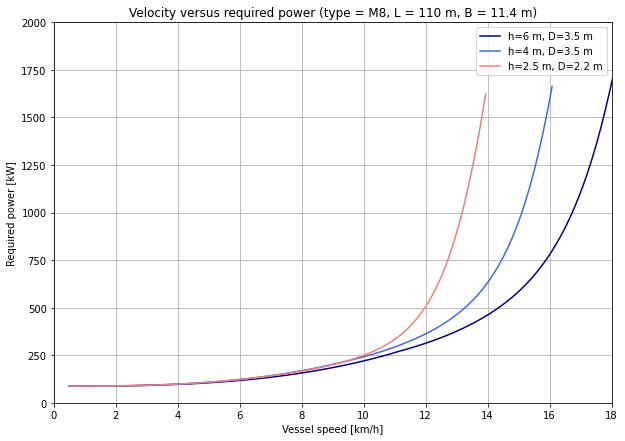

In [39]:
V_0_km = V_0 * 3.6

plt.figure(figsize = (10,7))
plt.plot(V_0_km[1:125], P_tot1[1:125], 'navy')
plt.plot(V_0_km[1:111], P_tot2[1:111], 'royalblue')
plt.plot(V_0_km[1:96], P_tot3[1:96], 'lightcoral')
# plt.plot(V_0_km, P_tot4, 'indianred')
# plt.plot(V_0_km, P_tot5, 'firebrick')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 2000)
plt.legend(['h=6 m, D=3.5 m', 'h=4 m, D=3.5 m', 'h=2.5 m, D=2.2 m', 'h = 4 m', 'h = 4 m'])
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Required power [kW]')
plt.title('Velocity versus required power (type = M8, L = 110 m, B = 11.4 m)')

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(V_0_km[1:125], P_tot1[1:125], 'navy')
plt.plot(V_0_km[1:111], P_tot2[1:111], 'royalblue')
plt.plot(V_0_km[1:96], P_tot3[1:96], 'lightcoral')
# plt.plot(V_0_km, P_tot4, 'indianred')
# plt.plot(V_0_km, P_tot5, 'firebrick')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 2000)
plt.legend(['h=6 m, D=3.5 m', 'h=4 m, D=3.5 m', 'h=2.5 m, D=2.2 m', 'h = 4 m', 'h = 4 m'])
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Required power [kW]')
plt.title('Velocity versus required power (type = M8, L = 110 m, B = 11.4 m)')

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(V_0_km[1:124], P_tot1[1:124], 'navy')
plt.plot(V_0_km[1:110], P_tot2[1:110], 'royalblue')
# plt.plot(V_0_km, P_tot3, 'lightcoral')
# plt.plot(V_0_km, P_tot4, 'indianred')
# plt.plot(V_0_km, P_tot5, 'firebrick')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 2000)
plt.legend(['h = 6', 'h = 4', 'h = 4', 'h = 4', 'h = 4'])
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Power [kW]')
plt.title('Velocity versus required power (type = M8, L = 110 m, B = 11.4 m, D = 3.5 m)')

In [ ]:
plt.figure(figsize = (10,7))
plt.plot(V_0_km, P_tot1)
plt.grid()
plt.xlim(0, 16)
plt.ylim(0, 1000)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Power [kW]')
plt.title('Velocity versus required power (type = M9, L = 135 m, B = 11.4 m, T = 2.75 m)')

## 7. Emission factors general

In [ ]:
P_partial1 = P_tot1 / P_installed

P_partial2 = P_tot2 / P_installed

P_partial3 = P_tot3 / P_installed

P_partial4 = P_tot4 / P_installed

P_partial5 = P_tot5 / P_installed

for i in range (len(P_partial1)):
    if P_partial1[i] > 1:
        P_partial1[i] = 1

    elif P_partial2[i] > 1:
        P_partial2[i] = 1

    elif P_partial3[i] > 1:
        P_partial3[i] = 1

    elif P_partial4[i] > 1:
        P_partial4[i] = 1

    elif P_partial5[i] > 1:
        P_partial5[i] = 1
    
c_year = 1970 #hardcoded, is in the model depended on weibull function
c_year1 = 1980
c_year2 = 1990
c_year3 = 2000
c_year4 = 2010
c_year5 = 2020


In [ ]:
def general_emissionfactor(c_year, L_w):
    if c_year < 1974:
        EM_CO2 = 756
        EM_PM10 = 0.6
        EM_NOX = 10.8
    elif 1975 <= c_year <= 1979:
        EM_CO2 = 730
        EM_PM10 = 0.6
        EM_NOX = 10.6
    elif 1980 <= c_year <= 1984:
        EM_CO2 = 714
        EM_PM10 = 0.6
        EM_NOX = 10.4
    elif 1985 <= c_year <= 1989:
        EM_CO2 = 698
        EM_PM10 = 0.5
        EM_NOX = 10.1
    elif 1990 <= c_year <= 1994:
        EM_CO2 = 698
        EM_PM10 = 0.4
        EM_NOX = 10.1
    elif 1995 <= c_year <= 2002:
        EM_CO2 = 650
        EM_PM10 = 0.3
        EM_NOX = 9.4
    elif 2003 <= c_year <= 2007:
        EM_CO2 = 635
        EM_PM10 = 0.3
        EM_NOX = 9.2
    elif 2008 <= c_year <= 2019:
        EM_CO2 = 635
        EM_PM10 = 0.2
        EM_NOX = 7
    elif c_year > 2019:
        if L == 1:
            EM_CO2 = 650
            EM_PM10 = 0.1
            EM_NOX = 2.9
        else:
            EM_CO2 = 603
            EM_PM10 = 0.015
            EM_NOX = 2.4
    return EM_CO2, EM_PM10, EM_NOX

general_emf = general_emissionfactor(c_year, 3)
general_emf1 = general_emissionfactor(c_year1, 3)
general_emf2 = general_emissionfactor(c_year2, 3)
general_emf3 = general_emissionfactor(c_year3, 3)
general_emf4 = general_emissionfactor(c_year4, 3)
general_emf5= general_emissionfactor(c_year5, 3)

## 8. Correction factors

In [ ]:
corf_CO2 = np.zeros(len(V_0))
corf_PM10 = np.zeros(len(V_0))
corf_NOX = np.zeros(len(V_0))

def correctionfactor(c_year, P_partial, L_w=3):
    corf = pd.read_excel (r'correctionfactors.xlsx')
    
    corf_CO2 = 0
    corf_PM10 = 0
    corf_NOX = 0
    
    #If P_partial is <= 5%
    
    if P_partial <= 0.05:
        corf_CO2 = corf.iloc[0, 5]
        corf_PM10 = corf.iloc[0, 6]
            
        if c_year < 2008:
            corf_NOX = corf.iloc[0, 1] #<= CCR-1 class
        elif 2008 <= c_year <= 2019:
            corf_NOX = corf.iloc[0, 2] #CCR-2 / Stage IIIa
        elif c_year > 2019:
                if L_w == 1:
                    corf_NOX = corf.iloc[0, 3] #Stage V: IWP/IWA-v/c-3 class (vessels with P <300 kW: assumed to be weight class L1)
                else:
                    corf_NOX = corf.iloc[0, 4]  #Stage V:IWP/IWA-v/c-4 class (vessels with P >300 kw: assumed to be weight class L2-L3)
    
    #If P_parital = 100% 
    
    elif P_partial == 1:
        corf_CO2 = corf.iloc[19, 5]
        corf_PM10 = corf.iloc[19, 6]
            
        if c_year < 2008:
            corf_NOX = corf.iloc[19, 1] #<= CCR-1 class
        elif 2008 <= c_year <= 2019:
            corf_NOX = corf.iloc[19, 2] #CCR-2 / Stage IIIa
        elif c_year > 2019:
            if L_w == 1:
                corf_NOX = corf.iloc[19, 3] #Stage V: IWP/IWA-v/c-3 class (vessels with P <300 kW: assumed to be weight class L1)
            else:
                corf_NOX = corf.iloc[19, 4]  #Stage V:IWP/IWA-v/c-4 class (vessels with P >300 kw: assumed to be weight class L2-L3) 
                
    #If P_partial is inbetween 5% and 100%. 
            
    elif 0.05 < P_partial < 1:
    
        #It is determined inbetween which two percentages in the table the partial engine load lies
        #The correction factor is determined by means of linear interpolation  
            
        for i in range(len(corf)):
            if corf.iloc[i, 0] < P_partial <= corf.iloc[i + 1, 0]: 
                
                corf_CO2 = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 5] - corf.iloc[i, 5])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 5]
                corf_PM10 = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 6] - corf.iloc[i, 6])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 6]

                if c_year < 2008:
                    corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 1] - corf.iloc[i, 1])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 1]
                elif 2008 <= c_year <= 2019:
                    corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 2] - corf.iloc[i, 2])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 2]
                elif c_year > 2019:
                    if L_w == 1:
                        corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 3] - corf.iloc[i, 3])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 3]
                    else:
                        corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 4] - corf.iloc[i, 4])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 4] 
    return corf_CO2, corf_PM10, corf_NOX

## 9. Emission rates plots

In [ ]:
#Emission rates for different water depths in g/h

emission_rate_CO2_1 = np.zeros(len(V_0))
emission_rate_CO2_2 = np.zeros(len(V_0))
emission_rate_CO2_3 = np.zeros(len(V_0))
emission_rate_CO2_4 = np.zeros(len(V_0))
emission_rate_CO2_5 = np.zeros(len(V_0))

emission_rate_PM10_1= np.zeros(len(V_0))
emission_rate_PM10_2= np.zeros(len(V_0))
emission_rate_PM10_3= np.zeros(len(V_0))
emission_rate_PM10_4= np.zeros(len(V_0))
emission_rate_PM10_5= np.zeros(len(V_0))

emission_rate_NOX_1 = np.zeros(len(V_0))
emission_rate_NOX_2 = np.zeros(len(V_0))
emission_rate_NOX_3 = np.zeros(len(V_0))
emission_rate_NOX_4 = np.zeros(len(V_0))
emission_rate_NOX_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    emission_rate_CO2_1[i] = P_tot1.item(i) * general_emf[0] * correctionfactor(c_year, P_partial1.item(i), 3)[0]
    emission_rate_CO2_2[i] = P_tot2.item(i) * general_emf[0] * correctionfactor(c_year, P_partial2.item(i), 3)[0]
    emission_rate_CO2_3[i] = P_tot3.item(i) * general_emf[0] * correctionfactor(c_year, P_partial3.item(i), 3)[0]
    emission_rate_CO2_4[i] = P_tot4.item(i) * general_emf[0] * correctionfactor(c_year, P_partial4.item(i), 3)[0]
    emission_rate_CO2_5[i] = P_tot5.item(i) * general_emf[0] * correctionfactor(c_year, P_partial5.item(i), 3)[0]
    
for i in range(len(V_0)):
    emission_rate_PM10_1[i] = P_tot1.item(i) * general_emf[1] * correctionfactor(c_year, P_partial1.item(i), 3)[1]
    emission_rate_PM10_2[i] = P_tot2.item(i) * general_emf[1] * correctionfactor(c_year, P_partial2.item(i), 3)[1]
    emission_rate_PM10_3[i] = P_tot3.item(i) * general_emf[1] * correctionfactor(c_year, P_partial3.item(i), 3)[1]
    emission_rate_PM10_4[i] = P_tot4.item(i) * general_emf[1] * correctionfactor(c_year, P_partial4.item(i), 3)[1]
    emission_rate_PM10_5[i] = P_tot5.item(i) * general_emf[1] * correctionfactor(c_year, P_partial5.item(i), 3)[1]

for i in range(len(V_0)):
    emission_rate_NOX_1[i] = P_tot1.item(i) * general_emf[2] * correctionfactor(c_year, P_partial1.item(i), 3)[2]
    emission_rate_NOX_2[i] = P_tot2.item(i) * general_emf[2] * correctionfactor(c_year, P_partial2.item(i), 3)[2]
    emission_rate_NOX_3[i] = P_tot3.item(i) * general_emf[2] * correctionfactor(c_year, P_partial3.item(i), 3)[2]
    emission_rate_NOX_4[i] = P_tot4.item(i) * general_emf[2] * correctionfactor(c_year, P_partial4.item(i), 3)[2]
    emission_rate_NOX_5[i] = P_tot5.item(i) * general_emf[2] * correctionfactor(c_year, P_partial5.item(i), 3)[2]



#print(emission_rate_PM10_1)

#emission_rate_CO2 = P_tot1 * general_emf[0] * correctionfactor(c_year, P_partial1, 3)

In [ ]:
#Emission rates in g/km for different water depths

emission_g_m_CO2_1 = np.zeros(len(V_0))
emission_g_m_CO2_2 = np.zeros(len(V_0))
emission_g_m_CO2_3 = np.zeros(len(V_0))
emission_g_m_CO2_4 = np.zeros(len(V_0))
emission_g_m_CO2_5 = np.zeros(len(V_0))

emission_g_m_PM10_1= np.zeros(len(V_0))
emission_g_m_PM10_2= np.zeros(len(V_0))
emission_g_m_PM10_3= np.zeros(len(V_0))
emission_g_m_PM10_4= np.zeros(len(V_0))
emission_g_m_PM10_5= np.zeros(len(V_0))

emission_g_m_NOX_1 = np.zeros(len(V_0))
emission_g_m_NOX_2 = np.zeros(len(V_0))
emission_g_m_NOX_3 = np.zeros(len(V_0))
emission_g_m_NOX_4 = np.zeros(len(V_0))
emission_g_m_NOX_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    emission_g_m_CO2_1[i] = P_tot1.item(i) * general_emf[0] * correctionfactor(c_year, P_partial1.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_2[i] = P_tot2.item(i) * general_emf[0] * correctionfactor(c_year, P_partial2.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_3[i] = P_tot3.item(i) * general_emf[0] * correctionfactor(c_year, P_partial3.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_4[i] = P_tot4.item(i) * general_emf[0] * correctionfactor(c_year, P_partial4.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_5[i] = P_tot5.item(i) * general_emf[0] * correctionfactor(c_year, P_partial5.item(i), 3)[0] /  V_0_km[i]
    
for i in range(len(V_0)):
    emission_g_m_PM10_1[i] = P_tot1.item(i) * general_emf[1] * correctionfactor(c_year, P_partial1.item(i), 3)[1] /  V_0_km[i]
    emission_g_m_PM10_2[i] = P_tot2.item(i) * general_emf[1] * correctionfactor(c_year, P_partial2.item(i), 3)[1] /  V_0_km[i]
    emission_g_m_PM10_3[i] = P_tot3.item(i) * general_emf[1] * correctionfactor(c_year, P_partial3.item(i), 3)[1] /  V_0_km[i]
    emission_g_m_PM10_4[i] = P_tot4.item(i) * general_emf[1] * correctionfactor(c_year, P_partial4.item(i), 3)[1] /  V_0_km[i]
    emission_g_m_PM10_5[i] = P_tot5.item(i) * general_emf[1] * correctionfactor(c_year, P_partial5.item(i), 3)[1] /  V_0_km[i]

for i in range(len(V_0)):
    emission_g_m_NOX_1[i] = P_tot1.item(i) * general_emf[2] * correctionfactor(c_year, P_partial1.item(i), 3)[2] /  V_0_km[i]
    emission_g_m_NOX_2[i] = P_tot2.item(i) * general_emf[2] * correctionfactor(c_year, P_partial2.item(i), 3)[2] /  V_0_km[i]
    emission_g_m_NOX_3[i] = P_tot3.item(i) * general_emf[2] * correctionfactor(c_year, P_partial3.item(i), 3)[2] /  V_0_km[i]
    emission_g_m_NOX_4[i] = P_tot4.item(i) * general_emf[2] * correctionfactor(c_year, P_partial4.item(i), 3)[2] /  V_0_km[i]
    emission_g_m_NOX_5[i] = P_tot5.item(i) * general_emf[2] * correctionfactor(c_year, P_partial5.item(i), 3)[2] /  V_0_km[i]



#print(emission_rate_PM10_1)

#emission_rate_CO2 = P_tot1 * general_emf[0] * correctionfactor(c_year, P_partial1, 3)

In [ ]:
#Emission rates in g/h for different engine ages

emission_rate_CO2_11 = np.zeros(len(V_0))
emission_rate_CO2_22 = np.zeros(len(V_0))
emission_rate_CO2_33 = np.zeros(len(V_0))
emission_rate_CO2_44 = np.zeros(len(V_0))
emission_rate_CO2_55 = np.zeros(len(V_0))
emission_rate_CO2_66 = np.zeros(len(V_0))

emission_rate_PM10_11= np.zeros(len(V_0))
emission_rate_PM10_22= np.zeros(len(V_0))
emission_rate_PM10_33= np.zeros(len(V_0))
emission_rate_PM10_44= np.zeros(len(V_0))
emission_rate_PM10_55= np.zeros(len(V_0))
emission_rate_PM10_66= np.zeros(len(V_0))

emission_rate_NOX_11 = np.zeros(len(V_0))
emission_rate_NOX_22 = np.zeros(len(V_0))
emission_rate_NOX_33 = np.zeros(len(V_0))
emission_rate_NOX_44 = np.zeros(len(V_0))
emission_rate_NOX_55 = np.zeros(len(V_0))
emission_rate_NOX_66 = np.zeros(len(V_0))

for i in range(len(V_0)):
    emission_rate_CO2_11[i] = P_tot1.item(i) * general_emf[0] * correctionfactor(c_year, P_partial1.item(i), 3)[0]
    emission_rate_CO2_22[i] = P_tot1.item(i) * general_emf1[0] * correctionfactor(c_year1, P_partial1.item(i), 3)[0]
    emission_rate_CO2_33[i] = P_tot1.item(i) * general_emf2[0] * correctionfactor(c_year2, P_partial1.item(i), 3)[0]
    emission_rate_CO2_44[i] = P_tot1.item(i) * general_emf3[0] * correctionfactor(c_year3, P_partial1.item(i), 3)[0]
    emission_rate_CO2_55[i] = P_tot1.item(i) * general_emf4[0] * correctionfactor(c_year4, P_partial1.item(i), 3)[0]
    emission_rate_CO2_66[i] = P_tot1.item(i) * general_emf5[0] * correctionfactor(c_year5, P_partial1.item(i), 3)[0]
    
for i in range(len(V_0)):
    emission_rate_PM10_11[i] = P_tot1.item(i) * general_emf[1] * correctionfactor(c_year, P_partial1.item(i), 3)[1]
    emission_rate_PM10_22[i] = P_tot1.item(i) * general_emf1[1] * correctionfactor(c_year1, P_partial1.item(i), 3)[1]
    emission_rate_PM10_33[i] = P_tot1.item(i) * general_emf2[1] * correctionfactor(c_year2, P_partial1.item(i), 3)[1]
    emission_rate_PM10_44[i] = P_tot1.item(i) * general_emf3[1] * correctionfactor(c_year3, P_partial1.item(i), 3)[1]
    emission_rate_PM10_55[i] = P_tot1.item(i) * general_emf4[1] * correctionfactor(c_year4, P_partial1.item(i), 3)[1]
    emission_rate_PM10_66[i] = P_tot1.item(i) * general_emf5[1] * correctionfactor(c_year5, P_partial1.item(i), 3)[1]
    
for i in range(len(V_0)):
    emission_rate_NOX_11[i] = P_tot1.item(i) * general_emf[2] * correctionfactor(c_year, P_partial1.item(i), 3)[2]
    emission_rate_NOX_22[i] = P_tot1.item(i) * general_emf1[2] * correctionfactor(c_year1, P_partial1.item(i), 3)[2]
    emission_rate_NOX_33[i] = P_tot1.item(i) * general_emf2[2] * correctionfactor(c_year2, P_partial1.item(i), 3)[2]
    emission_rate_NOX_44[i] = P_tot1.item(i) * general_emf3[2] * correctionfactor(c_year3, P_partial1.item(i), 3)[2]
    emission_rate_NOX_55[i] = P_tot1.item(i) * general_emf4[2] * correctionfactor(c_year4, P_partial1.item(i), 3)[2]
    emission_rate_NOX_66[i] = P_tot1.item(i) * general_emf5[2] * correctionfactor(c_year5, P_partial1.item(i), 3)[2]

In [ ]:
#Emission rates in g/m for different engine ages

emission_g_m_CO2_11 = np.zeros(len(V_0))
emission_g_m_CO2_22 = np.zeros(len(V_0))
emission_g_m_CO2_33 = np.zeros(len(V_0))
emission_g_m_CO2_44 = np.zeros(len(V_0))
emission_g_m_CO2_55 = np.zeros(len(V_0))
emission_g_m_CO2_66 = np.zeros(len(V_0))

emission_g_m_PM10_11 = np.zeros(len(V_0))
emission_g_m_PM10_22 = np.zeros(len(V_0))
emission_g_m_PM10_33 = np.zeros(len(V_0))
emission_g_m_PM10_44 = np.zeros(len(V_0))
emission_g_m_PM10_55 = np.zeros(len(V_0))
emission_g_m_PM10_66 = np.zeros(len(V_0))

emission_g_m_NOX_11 = np.zeros(len(V_0))
emission_g_m_NOX_22 = np.zeros(len(V_0))
emission_g_m_NOX_33 = np.zeros(len(V_0))
emission_g_m_NOX_44 = np.zeros(len(V_0))
emission_g_m_NOX_55 = np.zeros(len(V_0))
emission_g_m_NOX_66 = np.zeros(len(V_0))

for i in range(len(V_0)):
    emission_g_m_CO2_11[i] = P_tot1.item(i) * general_emf[0] * correctionfactor(c_year, P_partial1.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_22[i] = P_tot1.item(i) * general_emf1[0] * correctionfactor(c_year1, P_partial1.item(i), 3)[0] / V_0_km[i]
    emission_g_m_CO2_33[i] = P_tot1.item(i) * general_emf2[0] * correctionfactor(c_year2, P_partial1.item(i), 3)[0] / V_0_km[i]
    emission_g_m_CO2_44[i] = P_tot1.item(i) * general_emf3[0] * correctionfactor(c_year3, P_partial1.item(i), 3)[0] / V_0_km[i]
    emission_g_m_CO2_55[i] = P_tot1.item(i) * general_emf4[0] * correctionfactor(c_year4, P_partial1.item(i), 3)[0] / V_0_km[i]
    emission_g_m_CO2_66[i] = P_tot1.item(i) * general_emf5[0] * correctionfactor(c_year5, P_partial1.item(i), 3)[0] / V_0_km[i]
    
for i in range(len(V_0)):
    emission_g_m_PM10_11[i] = P_tot1.item(i) * general_emf[1] * correctionfactor(c_year, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_22[i] = P_tot1.item(i) * general_emf1[1] * correctionfactor(c_year1, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_33[i] = P_tot1.item(i) * general_emf2[1] * correctionfactor(c_year2, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_44[i] = P_tot1.item(i) * general_emf3[1] * correctionfactor(c_year3, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_55[i] = P_tot1.item(i) * general_emf4[1] * correctionfactor(c_year4, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_66[i] = P_tot1.item(i) * general_emf5[1] * correctionfactor(c_year5, P_partial1.item(i), 3)[1] / V_0_km[i]
    
for i in range(len(V_0)):
    emission_g_m_NOX_11[i] = P_tot1.item(i) * general_emf[2] * correctionfactor(c_year, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_22[i] = P_tot1.item(i) * general_emf1[2] * correctionfactor(c_year1, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_33[i] = P_tot1.item(i) * general_emf2[2] * correctionfactor(c_year2, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_44[i] = P_tot1.item(i) * general_emf3[2] * correctionfactor(c_year3, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_55[i] = P_tot1.item(i) * general_emf4[2] * correctionfactor(c_year4, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_66[i] = P_tot1.item(i) * general_emf5[2] * correctionfactor(c_year5, P_partial1.item(i), 3)[2] / V_0_km[i]

### Plots: Emission rates in g/s of CO2, PM10 and NOx as a function of the velocity, for different h 

In [ ]:
import matplotlib.pylab as plt
fig = plt.figure(figsize = (6,4))
plt.plot(V_0_km, emission_rate_CO2_1, 'yellow')
plt.plot(V_0_km, emission_rate_CO2_2, 'gold')
plt.plot(V_0_km, emission_rate_CO2_3, 'orange')
plt.plot(V_0_km, emission_rate_CO2_4, 'red')
plt.plot(V_0_km, emission_rate_CO2_5, 'darkred')
plt.legend(['h = 10', 'h = 7', 'h = 4', 'h = 3.5', 'h = 3'])
plt.grid()
plt.xlim(6, 18)
plt.ylim(0, 0.14*10**7)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/h]')
#fig.suptitle('CO2 emission rate versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')
#plt.title('CO2 emission rate versus V0 (L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')

fig = plt.figure(figsize = (6,4))
plt.plot(V_0_km, emission_rate_PM10_1, 'aquamarine')
plt.plot(V_0_km, emission_rate_PM10_2, 'mediumspringgreen')
plt.plot(V_0_km, emission_rate_PM10_3, 'mediumseagreen')
plt.plot(V_0_km, emission_rate_PM10_4, 'seagreen')
plt.plot(V_0_km, emission_rate_PM10_5, 'darkgreen')
plt.legend(['h = 10', 'h = 7', 'h = 4', 'h = 3.5', 'h = 3'])
plt.grid()
plt.xlim(6, 18)
plt.ylim(0, 1200)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/h]')
#fig.suptitle('PM10 emission rate versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')


fig = plt.figure(figsize = (6,4))
plt.plot(V_0_km, emission_rate_NOX_1, 'pink')
plt.plot(V_0_km, emission_rate_NOX_2, 'hotpink')
plt.plot(V_0_km, emission_rate_NOX_3, 'deeppink')
plt.plot(V_0_km, emission_rate_NOX_4, 'orchid')
plt.plot(V_0_km, emission_rate_NOX_5, 'purple')
plt.legend(['h = 10', 'h = 7', 'h = 4', 'h = 3.5', 'h = 3'])
plt.grid()
plt.xlim(6, 18)
plt.ylim(0, 20000)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/h]')
#fig.suptitle('NOX emission rate versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')

### Emission rates in g/m of CO2, PM10 and NOx as a function of the velocity, for different h 

In [ ]:
import matplotlib.pylab as plt
fig = plt.figure(figsize = (4,3))
plt.plot(V_0_km, emission_g_m_CO2_1, 'yellow')
plt.plot(V_0_km, emission_g_m_CO2_2, 'gold')
plt.plot(V_0_km, emission_g_m_CO2_3, 'orange')
plt.plot(V_0_km, emission_g_m_CO2_4, 'red')
plt.plot(V_0_km, emission_g_m_CO2_5, 'darkred')
plt.legend(['h = 10', 'h = 7', 'h = 4', 'h = 3.5', 'h = 3'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 100000)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('CO2 emission rate [g/km]')
#fig.suptitle('CO2 emission rate in g/m versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')
#plt.title('CO2 emission rate versus V0 (L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')

fig = plt.figure(figsize = (4,3))
plt.plot(V_0_km, emission_g_m_PM10_1, 'aquamarine')
plt.plot(V_0_km, emission_g_m_PM10_2, 'mediumspringgreen')
plt.plot(V_0_km, emission_g_m_PM10_3, 'mediumseagreen')
plt.plot(V_0_km, emission_g_m_PM10_4, 'seagreen')
plt.plot(V_0_km, emission_g_m_PM10_5, 'darkgreen')
plt.legend(['h = 10', 'h = 7', 'h = 4', 'h = 3.5', 'h = 3'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 100)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('PM10 emission rate [g/km]')
#fig.suptitle('PM10 emission rate in g/m versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')


fig = plt.figure(figsize = (4,3))
plt.plot(V_0_km, emission_g_m_NOX_1, 'pink')
plt.plot(V_0_km, emission_g_m_NOX_2, 'hotpink')
plt.plot(V_0_km, emission_g_m_NOX_3, 'deeppink')
plt.plot(V_0_km, emission_g_m_NOX_4, 'orchid')
plt.plot(V_0_km, emission_g_m_NOX_5, 'purple')
plt.legend(['h = 10', 'h = 7', 'h = 4', 'h = 3.5', 'h = 3'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 1600)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('NOx emission rate [g/km]')
#fig.suptitle('NOX emission rate in g/m versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')

In [ ]:
import matplotlib.pylab as plt
fig = plt.figure(figsize = (4,3))
plt.plot(V_0_km, emission_g_m_CO2_1, 'orange')
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 100000)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('CO2 emission rate [g/km]')
#fig.suptitle('CO2 emission rate in g/m versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')
#plt.title('CO2 emission rate versus V0 (L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')

fig = plt.figure(figsize = (4,3))
plt.plot(V_0_km, emission_g_m_PM10_1, 'mediumseagreen')
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 100)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('PM10 emission rate [g/km]')
#fig.suptitle('PM10 emission rate in g/m versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')


fig = plt.figure(figsize = (4,3))
plt.plot(V_0_km, emission_g_m_NOX_1, 'deeppink')
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 1600)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('NOx emission rate [g/km]')
#fig.suptitle('NOX emission rate in g/m versus velocity, for different water depths \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')

### Emission rates as a function of the partial engine load

In [ ]:
import matplotlib.pylab as plt

fig = plt.figure(figsize = (10,7))
plt.plot(P_partial1, emission_rate_CO2_1, 'mediumturquoise')
plt.grid()
plt.xlim(0.1, 0.5)
plt.xlabel('Partial engine load (= P_tot / P-installed) [-]')
plt.ylabel('Emission rate [g/h]')
fig.suptitle('CO2 emission rate versus partial engine load \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990, h = 10 m)')


fig = plt.figure(figsize = (10,7))
plt.plot(P_partial1, emission_rate_PM10_1, 'blueviolet')
plt.grid()
plt.xlim(0.1, 0.5)
plt.xlabel('Partial engine load (= P_tot / P-installed) [-]')
plt.ylabel('Emission rate [g/h]')
fig.suptitle('PM10 emission rate versus partial engine load \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990, h = 10 m)')


fig = plt.figure(figsize = (10,7))
plt.plot(P_partial1, emission_rate_NOX_1, 'coral')
plt.grid()
plt.xlim(0.1, 0.5)
plt.xlabel('Partial engine load (= P_tot / P-installed) [-]')
plt.ylabel('Emission rate [g/h]')
fig.suptitle('NOX emission rate versus partial engine load \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990, h = 10 m)')



In [ ]:
fig = plt.figure(figsize = (10,7))
plt.plot(V_0_km, P_partial1, 'red')
plt.grid()
plt.xlabel('Vessel speed [km/h]')
plt.xlim(0, 18)
plt.ylim(0, 0.6)
plt.ylabel('Partial engine load (= P_tot / P-installed) [-]')
fig.suptitle('Partial engine load as a function of the vessel speed \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990, h = 10 m)')


## Emission rate in g/s as a function of the velocity, for different engine ages (h=10)

In [ ]:
fig = plt.figure(figsize = (6,4))
plt.plot(V_0_km, emission_rate_CO2_11, 'darkred')
plt.plot(V_0_km, emission_rate_CO2_22, 'red')
plt.plot(V_0_km, emission_rate_CO2_33, 'darkorange')
plt.plot(V_0_km, emission_rate_CO2_44, 'orange')
plt.plot(V_0_km, emission_rate_CO2_55, 'gold')
plt.plot(V_0_km, emission_rate_CO2_66, 'yellow')
plt.legend(['c_year = 1970', 'c_year = 1980', 'c_year = 1990', 'c_year = 2000', 'c_year = 2010', 'c_year = 2020'])
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 1000000)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/h]')
#fig.suptitle('CO2 emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')
#plt.title('CO2 emission rate versus V0 (L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')


fig = plt.figure(figsize = (6,4))
plt.plot(V_0_km, emission_rate_PM10_11, 'darkgreen')
plt.plot(V_0_km, emission_rate_PM10_22, 'seagreen')
plt.plot(V_0_km, emission_rate_PM10_33, 'mediumseagreen')
plt.plot(V_0_km, emission_rate_PM10_44, 'mediumspringgreen')
plt.plot(V_0_km, emission_rate_PM10_55, 'aquamarine')
plt.plot(V_0_km, emission_rate_PM10_66, 'paleturquoise')
plt.legend(['c_year = 1970', 'c_year = 1980', 'c_year = 1990', 'c_year = 2000', 'c_year = 2010', 'c_year = 2020'])
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 700)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/h]')
#fig.suptitle('PM10 emission rate versus velocity, for different engine ages \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')


fig = plt.figure(figsize = (6,4))
plt.plot(V_0_km, emission_rate_NOX_11, 'purple')
plt.plot(V_0_km, emission_rate_NOX_22, 'darkmagenta')
plt.plot(V_0_km, emission_rate_NOX_33, 'orchid')
plt.plot(V_0_km, emission_rate_NOX_44, 'deeppink')
plt.plot(V_0_km, emission_rate_NOX_55, 'hotpink')
plt.plot(V_0_km, emission_rate_NOX_66, 'pink')
plt.legend(['c_year = 1970', 'c_year = 1980', 'c_year = 1990', 'c_year = 2000', 'c_year = 2010', 'c_year = 2020'])
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 14000)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/h]')
#fig.suptitle('NOX emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')

## Emission rate in g/m as a function of the velocity, for different engine ages (h=10)

In [ ]:
fig = plt.figure(figsize = (10,7))
plt.plot(V_0_km, emission_g_m_CO2_11, 'darkred')
plt.plot(V_0_km, emission_g_m_CO2_22, 'red')
plt.plot(V_0_km, emission_g_m_CO2_33, 'darkorange')
plt.plot(V_0_km, emission_g_m_CO2_44, 'orange')
plt.plot(V_0_km, emission_g_m_CO2_55, 'gold')
plt.plot(V_0_km, emission_g_m_CO2_66, 'yellow')
plt.legend(['c_year = 1970', 'c_year = 1980', 'c_year = 1990', 'c_year = 2000', 'c_year = 2010', 'c_year = 2020'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 100000)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/km]')
#fig.suptitle('CO2 emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')
#plt.title('CO2 emission rate versus V0 (L = 135 m, B = 11.75 m, T = 2.75 m, c_year = 1990)')

fig = plt.figure(figsize = (10,7))
plt.plot(V_0_km, emission_g_m_PM10_11, 'darkgreen')
plt.plot(V_0_km, emission_g_m_PM10_22, 'seagreen')
plt.plot(V_0_km, emission_g_m_PM10_33, 'mediumseagreen')
plt.plot(V_0_km, emission_g_m_PM10_44, 'mediumspringgreen')
plt.plot(V_0_km, emission_g_m_PM10_55, 'aquamarine')
plt.plot(V_0_km, emission_g_m_PM10_66, 'paleturquoise')
plt.legend(['c_year = 1970', 'c_year = 1980', 'c_year = 1990', 'c_year = 2000', 'c_year = 2010', 'c_year = 2020'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 100)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/km]')
#fig.suptitle('PM10 emission rate versus velocity, for different engine ages \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')

fig = plt.figure(figsize = (10,7))
plt.plot(V_0_km, emission_g_m_NOX_11, 'purple')
plt.plot(V_0_km, emission_g_m_NOX_22, 'darkmagenta')
plt.plot(V_0_km, emission_g_m_NOX_33, 'orchid')
plt.plot(V_0_km, emission_g_m_NOX_44, 'deeppink')
plt.plot(V_0_km, emission_g_m_NOX_55, 'hotpink')
plt.plot(V_0_km, emission_g_m_NOX_66, 'pink')
plt.legend(['c_year = 1970', 'c_year = 1980', 'c_year = 1990', 'c_year = 2000', 'c_year = 2010', 'c_year = 2020'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0, 1600)
plt.xlabel('Vessel speed [km/h]')
plt.ylabel('Emission rate [g/km]')
#fig.suptitle('NOX emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')